In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore
# # step one, dannce alignment
import os
import sys
sys.path.append(os.path.abspath('../..'))

rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

# Assuming df_merged_with_dF_F is already loaded
# Extract columns that correspond to neurons
neuron_columns = [col for col in df_merged_with_dF_F.columns if col.startswith('dF_F_roi')]
neuron_activity = df_merged_with_dF_F[neuron_columns].values  # shape: (timepoints, neurons)

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# Step to drop low-variance neurons (reduce false positives)
neuron_variances = np.var(neuron_activity, axis=1)  # Variance for each neuron
threshold = np.percentile(neuron_variances, 5)      # Keep top 95% variance
high_variance_indices = neuron_variances > threshold  # Mask for neurons to keep

# Filter neuron activity and neuron column names
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# Optional: Z-score normalization along each neuron's time course
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)
# 'correlation' is often a good metric for neural activity, but you can try 'euclidean'.
# 'average' linkage is a common choice, but feel free to experiment (e.g., 'ward', 'complete').
# Perform hierarchical clustering on the filtered and normalized data
Z = linkage(neuron_activity_normalized, method='average', metric='correlation')

df_new = df_merged_with_dF_F.copy()
df_new = df_new.reset_index()
time = df_new['timestamp_ms_mini']

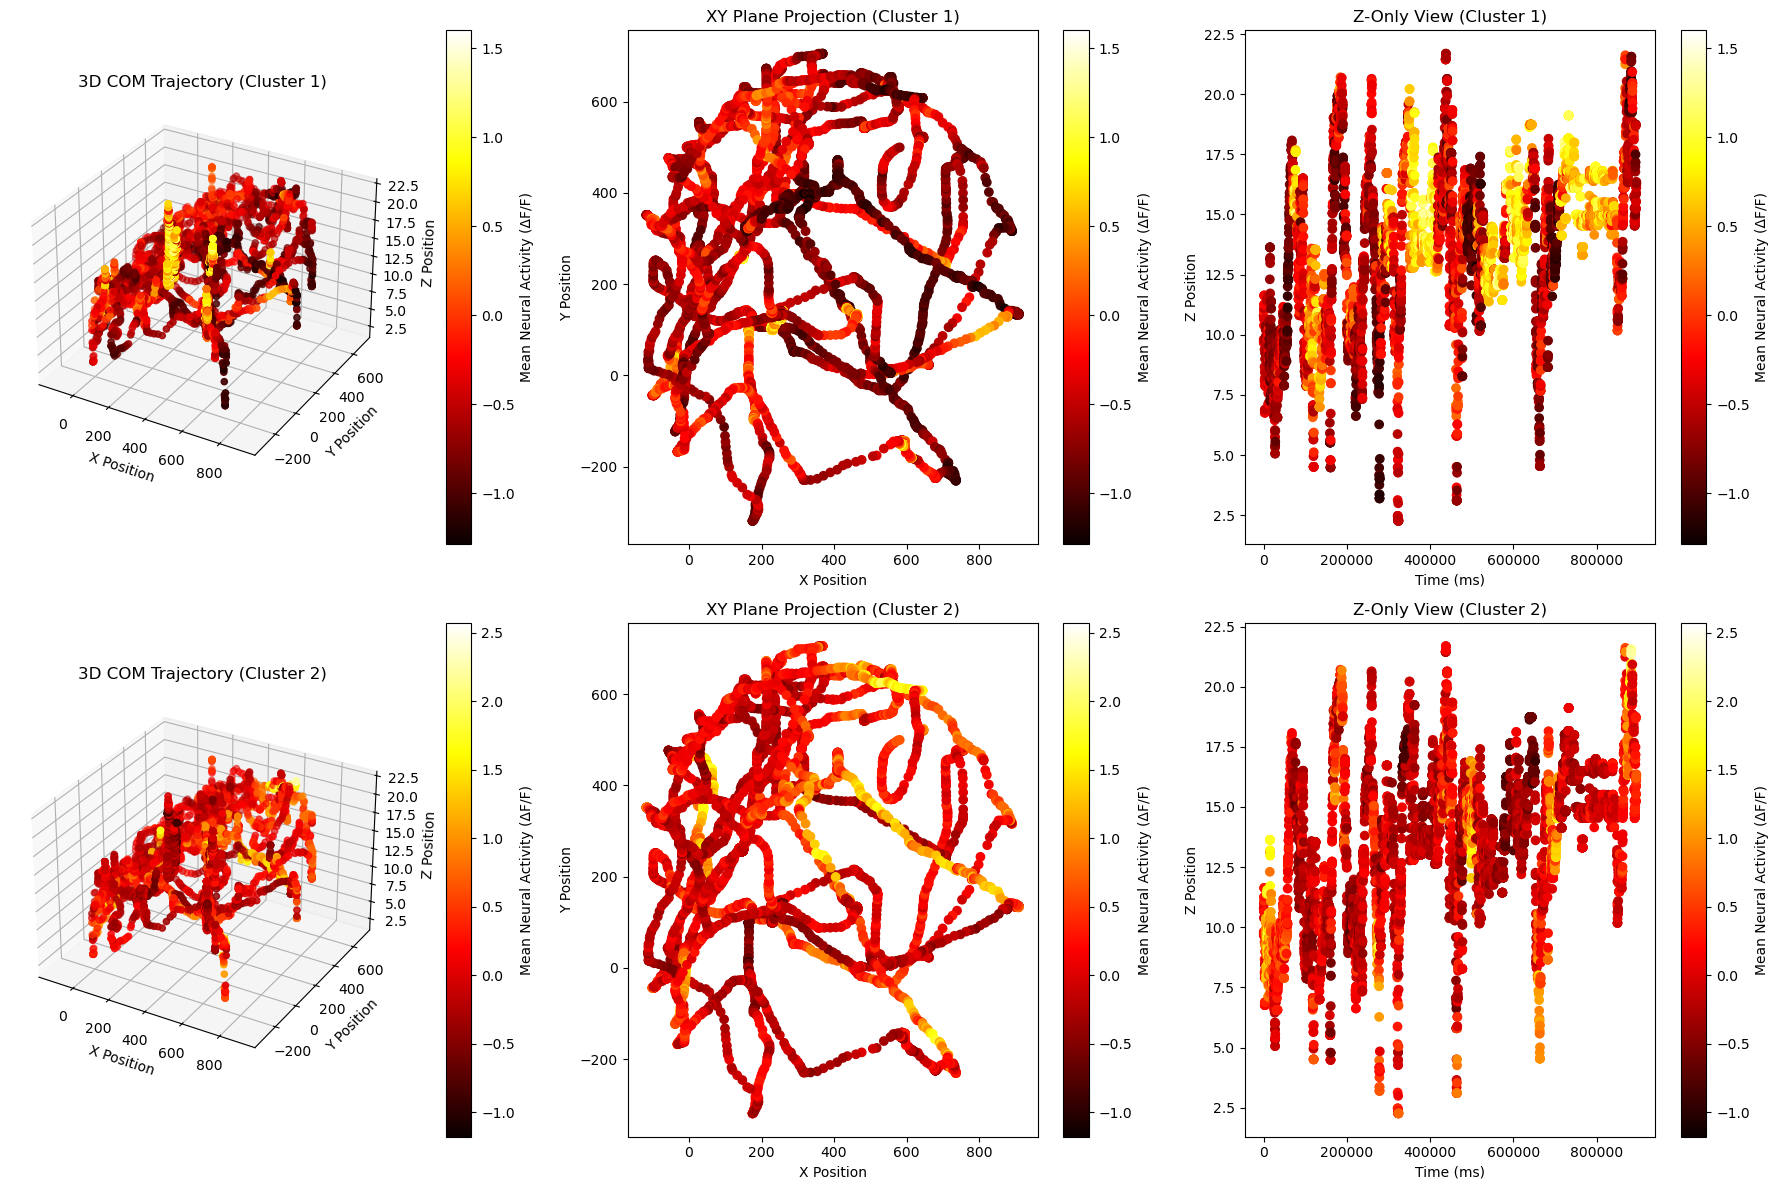

In [3]:
from scipy.cluster.hierarchy import fcluster
# df_new = df_new.reset_index()


# time = df_new['timestamp_ms_mini']
# Step 1: Assign neurons to clusters
num_clusters = 2
cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')  # Cluster labels for neurons (1 or 2)

# Step 2: Compute mean activity for each cluster
cluster_means = []
for cluster_id in range(1, num_clusters + 1):
    # Select neurons in the current cluster
    cluster_neurons = neuron_activity_normalized[cluster_labels == cluster_id, :]
    # Compute mean activity across neurons in this cluster
    cluster_mean = cluster_neurons.mean(axis=0)
    cluster_means.append(cluster_mean)

# Convert to a NumPy array for easier indexing
cluster_means = np.array(cluster_means)

# Step 3: Create plots for each cluster
fig = plt.figure(figsize=(18, 12))

# Plot for each cluster
for cluster_id in range(num_clusters):
    row_offset = cluster_id * 3  # Offset for each cluster's row

    # 3D Scatter Plot
    ax1 = fig.add_subplot(2, 3, row_offset + 1, projection='3d')
    scatter = ax1.scatter(
        df_new['com_x'], df_new['com_y'], df_new['com_z'],
        c=cluster_means[cluster_id, :len(df_new['com_x'])],  # Cluster mean activity
        cmap='hot', marker='o'
    )
    ax1.set_title(f'3D COM Trajectory (Cluster {cluster_id + 1})')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_zlabel('Z Position')
    fig.colorbar(scatter, ax=ax1, pad=0.1, label='Mean Neural Activity (ΔF/F)')

    # XY Plane Projection
    ax2 = fig.add_subplot(2, 3, row_offset + 2)
    scatter_xy = ax2.scatter(
        df_new['com_x'], df_new['com_y'],
        c=cluster_means[cluster_id, :len(df_new['com_x'])],  # Cluster mean activity
        cmap='hot', marker='o'
    )
    ax2.set_title(f'XY Plane Projection (Cluster {cluster_id + 1})')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    fig.colorbar(scatter_xy, ax=ax2, label='Mean Neural Activity (ΔF/F)')

    # Z-Only View
    ax3 = fig.add_subplot(2, 3, row_offset + 3)
    scatter_z = ax3.scatter(
        time, df_new['com_z'],
        c=cluster_means[cluster_id, :len(df_new['com_z'])],  # Cluster mean activity
        cmap='hot', marker='o'
    )
    ax3.set_title(f'Z-Only View (Cluster {cluster_id + 1})')
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Z Position')
    fig.colorbar(scatter_z, ax=ax3, label='Mean Neural Activity (ΔF/F)')

plt.tight_layout()
plt.show()


In [19]:
import numpy as np

# Extract coordinates
com_x = df_new['com_x'].values
com_y = df_new['com_y'].values
com_z = df_new['com_z'].values

# Compute displacement vectors
delta_x = np.diff(com_x)  # Change in X
delta_y = np.diff(com_y)  # Change in Y
delta_z = np.diff(com_z)  # Change in Z



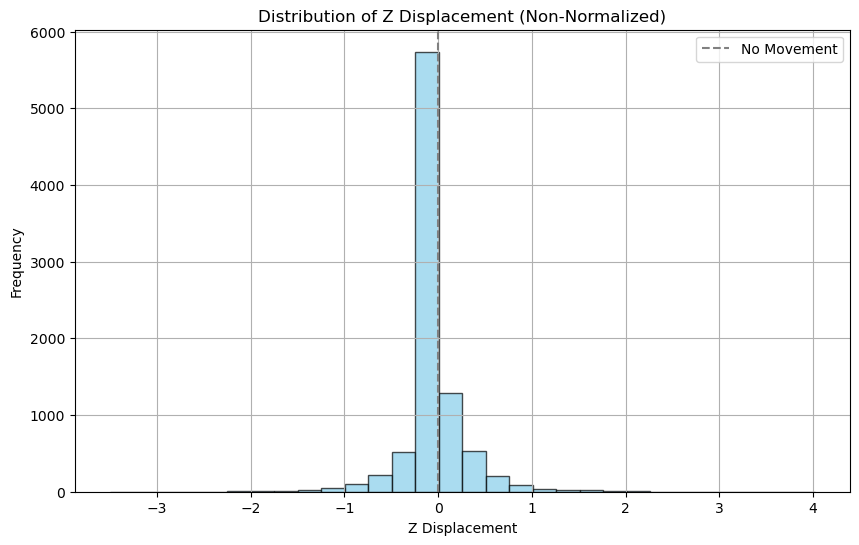

In [18]:
# Plot the histogram of non-normalized Z displacement (delta_z)
plt.figure(figsize=(10, 6))
plt.hist(delta_z, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.xlabel('Z Displacement')
plt.ylabel('Frequency')
plt.title('Distribution of Z Displacement (Non-Normalized)')
plt.axvline(0, color='gray', linestyle='--', label='No Movement')
plt.legend()
plt.grid(True)
plt.show()


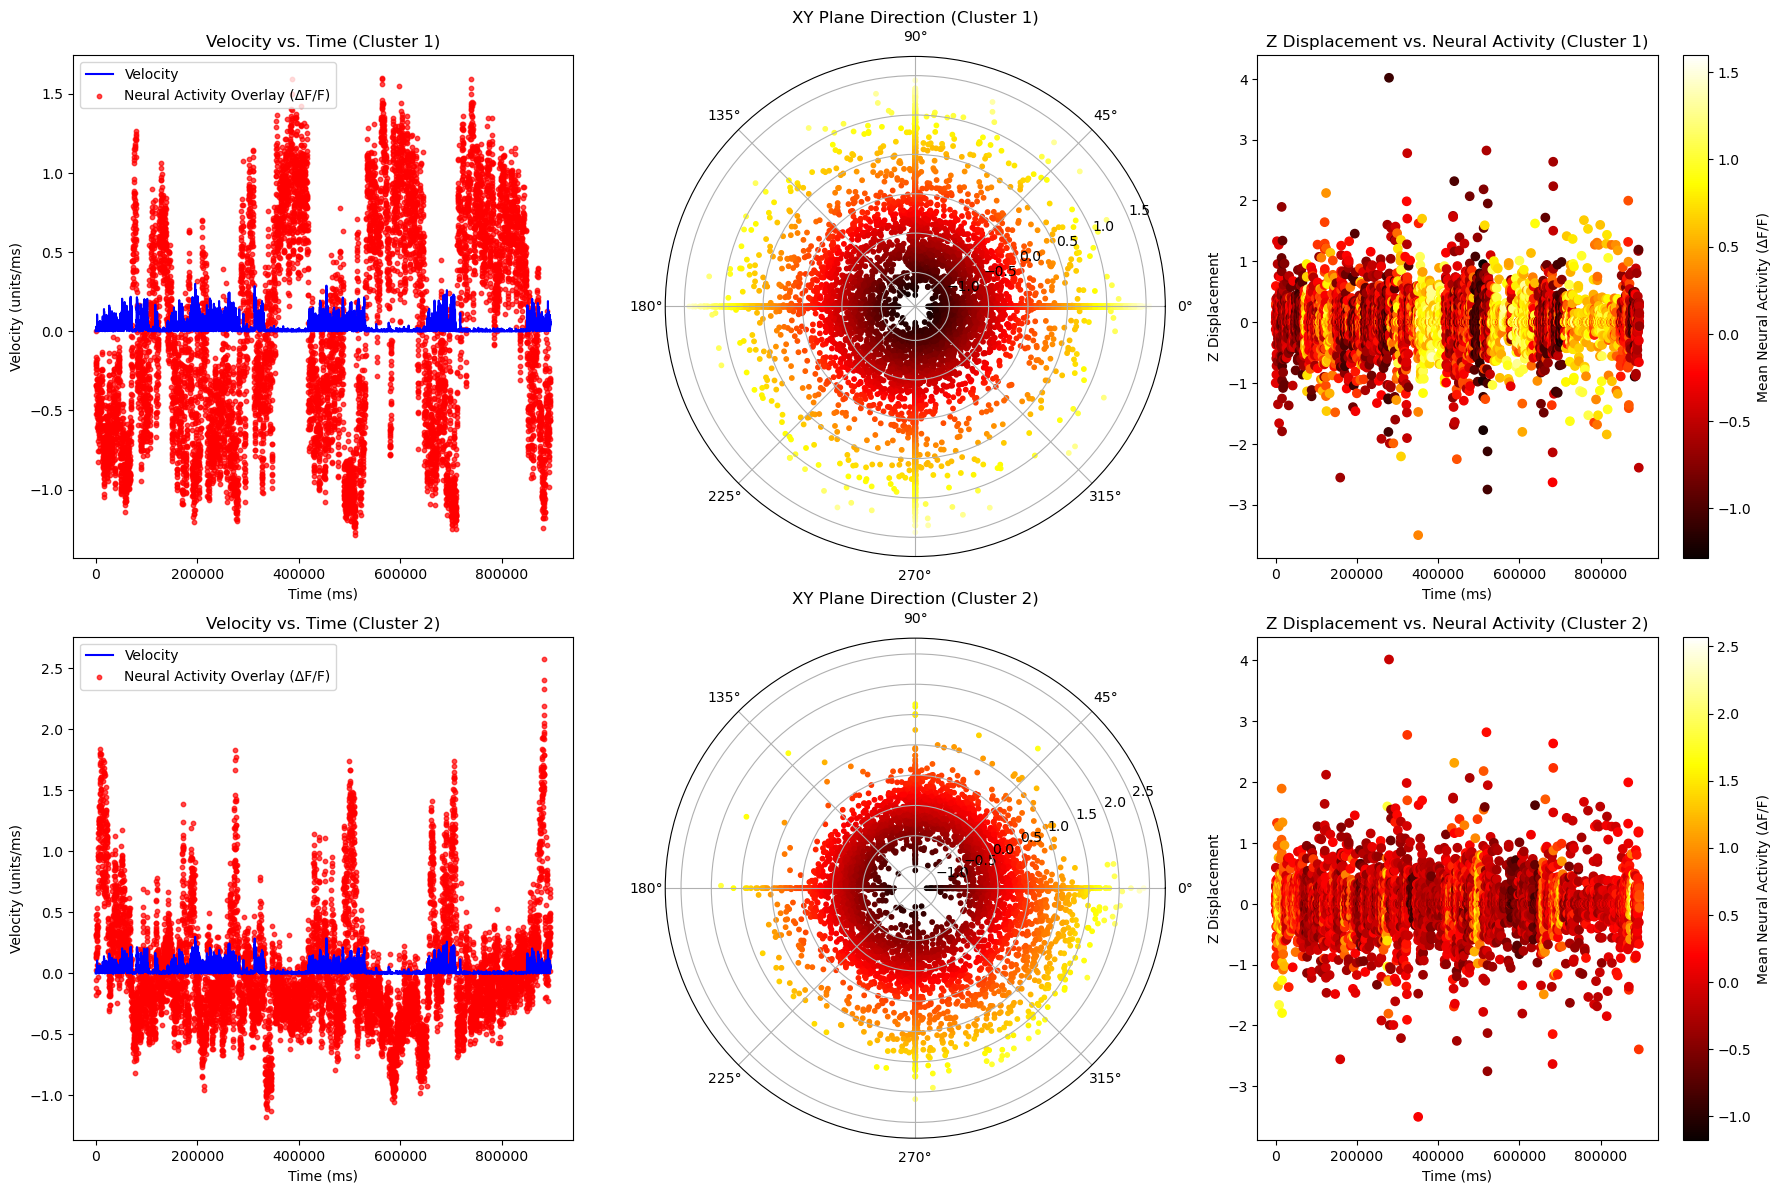

In [22]:
# Compute velocity, XY direction, and Z displacement
df_new['v_x'] = df_new['com_x'].diff() / time.diff()
df_new['v_y'] = df_new['com_y'].diff() / time.diff()
df_new['v_z'] = df_new['com_z'].diff() / time.diff()
df_new['velocity'] = np.sqrt(df_new['v_x']**2 + df_new['v_y']**2 + df_new['v_z']**2)
df_new['xy_direction'] = np.arctan2(df_new['com_y'].diff(), df_new['com_x'].diff())
df_new['z_displacement'] = df_new['com_z'].diff()

# Normalize time differences to handle NaN values in velocity calculation
df_new['velocity'] = df_new['velocity'].fillna(0)
df_new['z_displacement'] = df_new['z_displacement'].fillna(0)

# Plot detailed analysis with overlays
fig = plt.figure(figsize=(18, 12))

for cluster_id in range(num_clusters):
    row_offset = cluster_id * 3  # Offset for each cluster's row

    # Velocity vs. Time
    ax1 = fig.add_subplot(2, 3, row_offset + 1)
    ax1.plot(time, df_new['velocity'], label='Velocity', color='blue')
    ax1.scatter(time, cluster_means[cluster_id, :len(df_new['velocity'])],
                c='red', s=10, label='Neural Activity Overlay (ΔF/F)', alpha=0.7)
    ax1.set_title(f'Velocity vs. Time (Cluster {cluster_id + 1})')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Velocity (units/ms)')
    ax1.legend()

    # XY Direction with Neural Overlay
    ax2 = fig.add_subplot(2, 3, row_offset + 2, polar=True)
    ax2.scatter(df_new['xy_direction'], cluster_means[cluster_id, :len(df_new['xy_direction'])],
                c=cluster_means[cluster_id, :len(df_new['xy_direction'])], cmap='hot', s=10)
    ax2.set_title(f'XY Plane Direction (Cluster {cluster_id + 1})')

    # Z Displacement vs. Neural Activity
    ax3 = fig.add_subplot(2, 3, row_offset + 3)
    scatter_z = ax3.scatter(
        time, df_new['z_displacement'],
        c=cluster_means[cluster_id, :len(df_new['z_displacement'])], cmap='hot', marker='o'
    )
    ax3.set_title(f'Z Displacement vs. Neural Activity (Cluster {cluster_id + 1})')
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Z Displacement')
    fig.colorbar(scatter_z, ax=ax3, label='Mean Neural Activity (ΔF/F)')

plt.tight_layout()
plt.show()


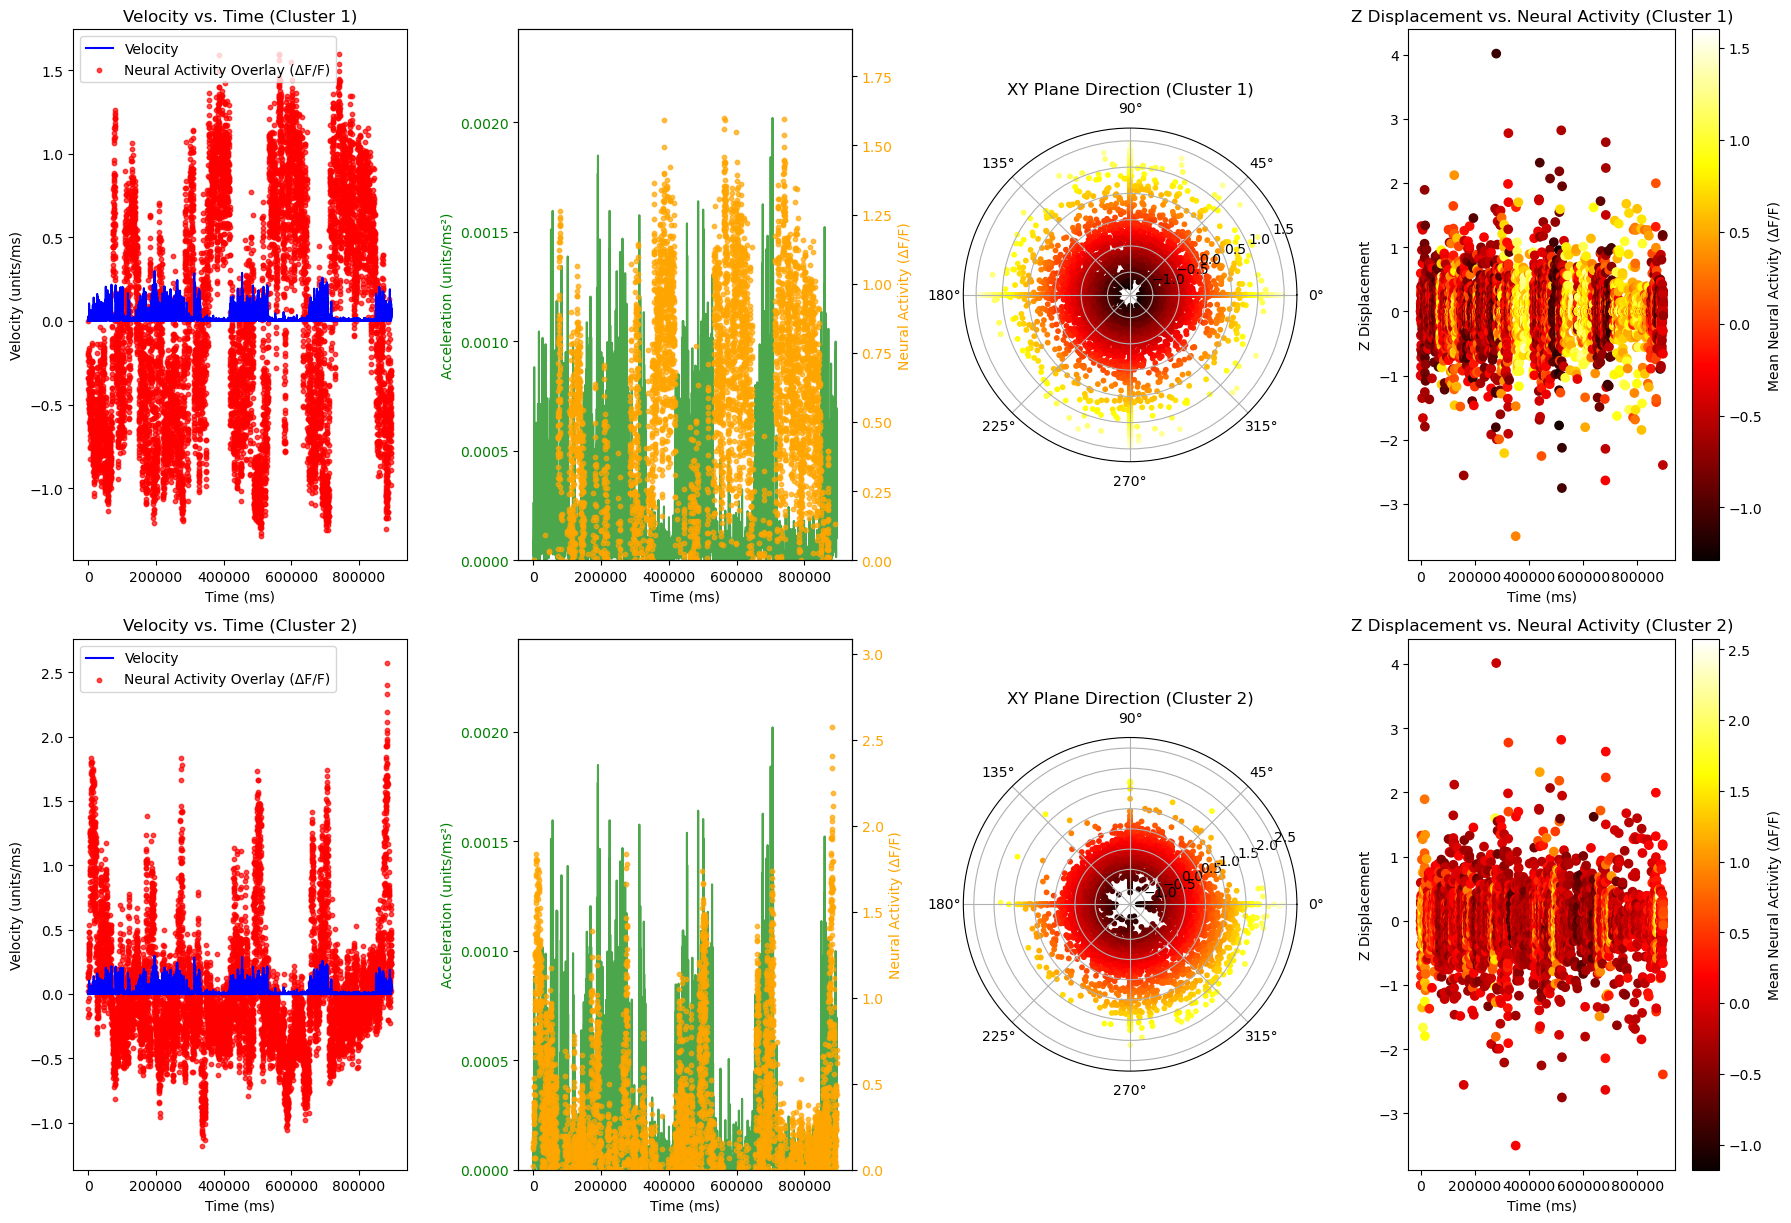

In [26]:
# Plot detailed analysis with acceleration overlays and dual y-axis
fig = plt.figure(figsize=(18, 18))

for cluster_id in range(num_clusters):
    row_offset = cluster_id * 4  # Offset for each cluster's row

    # Velocity vs. Time
    ax1 = fig.add_subplot(3, 4, row_offset + 1)
    ax1.plot(time, df_new['velocity'], label='Velocity', color='blue')
    ax1.scatter(time, cluster_means[cluster_id, :len(df_new['velocity'])],
                c='red', s=10, label='Neural Activity Overlay (ΔF/F)', alpha=0.7)
    ax1.set_title(f'Velocity vs. Time (Cluster {cluster_id + 1})')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Velocity (units/ms)')
    ax1.legend()

    # Acceleration vs. Time with dual y-axis
    ax2 = fig.add_subplot(3, 4, row_offset + 2)
    ax2.plot(time, df_new['acceleration'], label='Acceleration', color='green', alpha=0.7)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Acceleration (units/ms²)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(0, df_new['acceleration'].max() * 1.2)  # Expand range for acceleration

    # Add a secondary y-axis for neural activity
    ax2_2 = ax2.twinx()
    ax2_2.scatter(time, cluster_means[cluster_id, :len(df_new['acceleration'])],
                  c='orange', s=10, label='Neural Activity (ΔF/F)', alpha=0.7)
    ax2_2.set_ylabel('Neural Activity (ΔF/F)', color='orange')
    ax2_2.tick_params(axis='y', labelcolor='orange')
    ax2_2.set_ylim(0, cluster_means[cluster_id, :len(df_new['acceleration'])].max() * 1.2)  # Expand range for neural activity

    # XY Direction with Neural Overlay
    ax3 = fig.add_subplot(3, 4, row_offset + 3, polar=True)
    ax3.scatter(df_new['xy_direction'], cluster_means[cluster_id, :len(df_new['xy_direction'])],
                c=cluster_means[cluster_id, :len(df_new['xy_direction'])], cmap='hot', s=10)
    ax3.set_title(f'XY Plane Direction (Cluster {cluster_id + 1})')

    # Z Displacement vs. Neural Activity
    ax4 = fig.add_subplot(3, 4, row_offset + 4)
    scatter_z = ax4.scatter(
        time, df_new['z_displacement'],
        c=cluster_means[cluster_id, :len(df_new['z_displacement'])], cmap='hot', marker='o'
    )
    ax4.set_title(f'Z Displacement vs. Neural Activity (Cluster {cluster_id + 1})')
    ax4.set_xlabel('Time (ms)')
    ax4.set_ylabel('Z Displacement')
    fig.colorbar(scatter_z, ax=ax4, label='Mean Neural Activity (ΔF/F)')

plt.tight_layout()
plt.show()


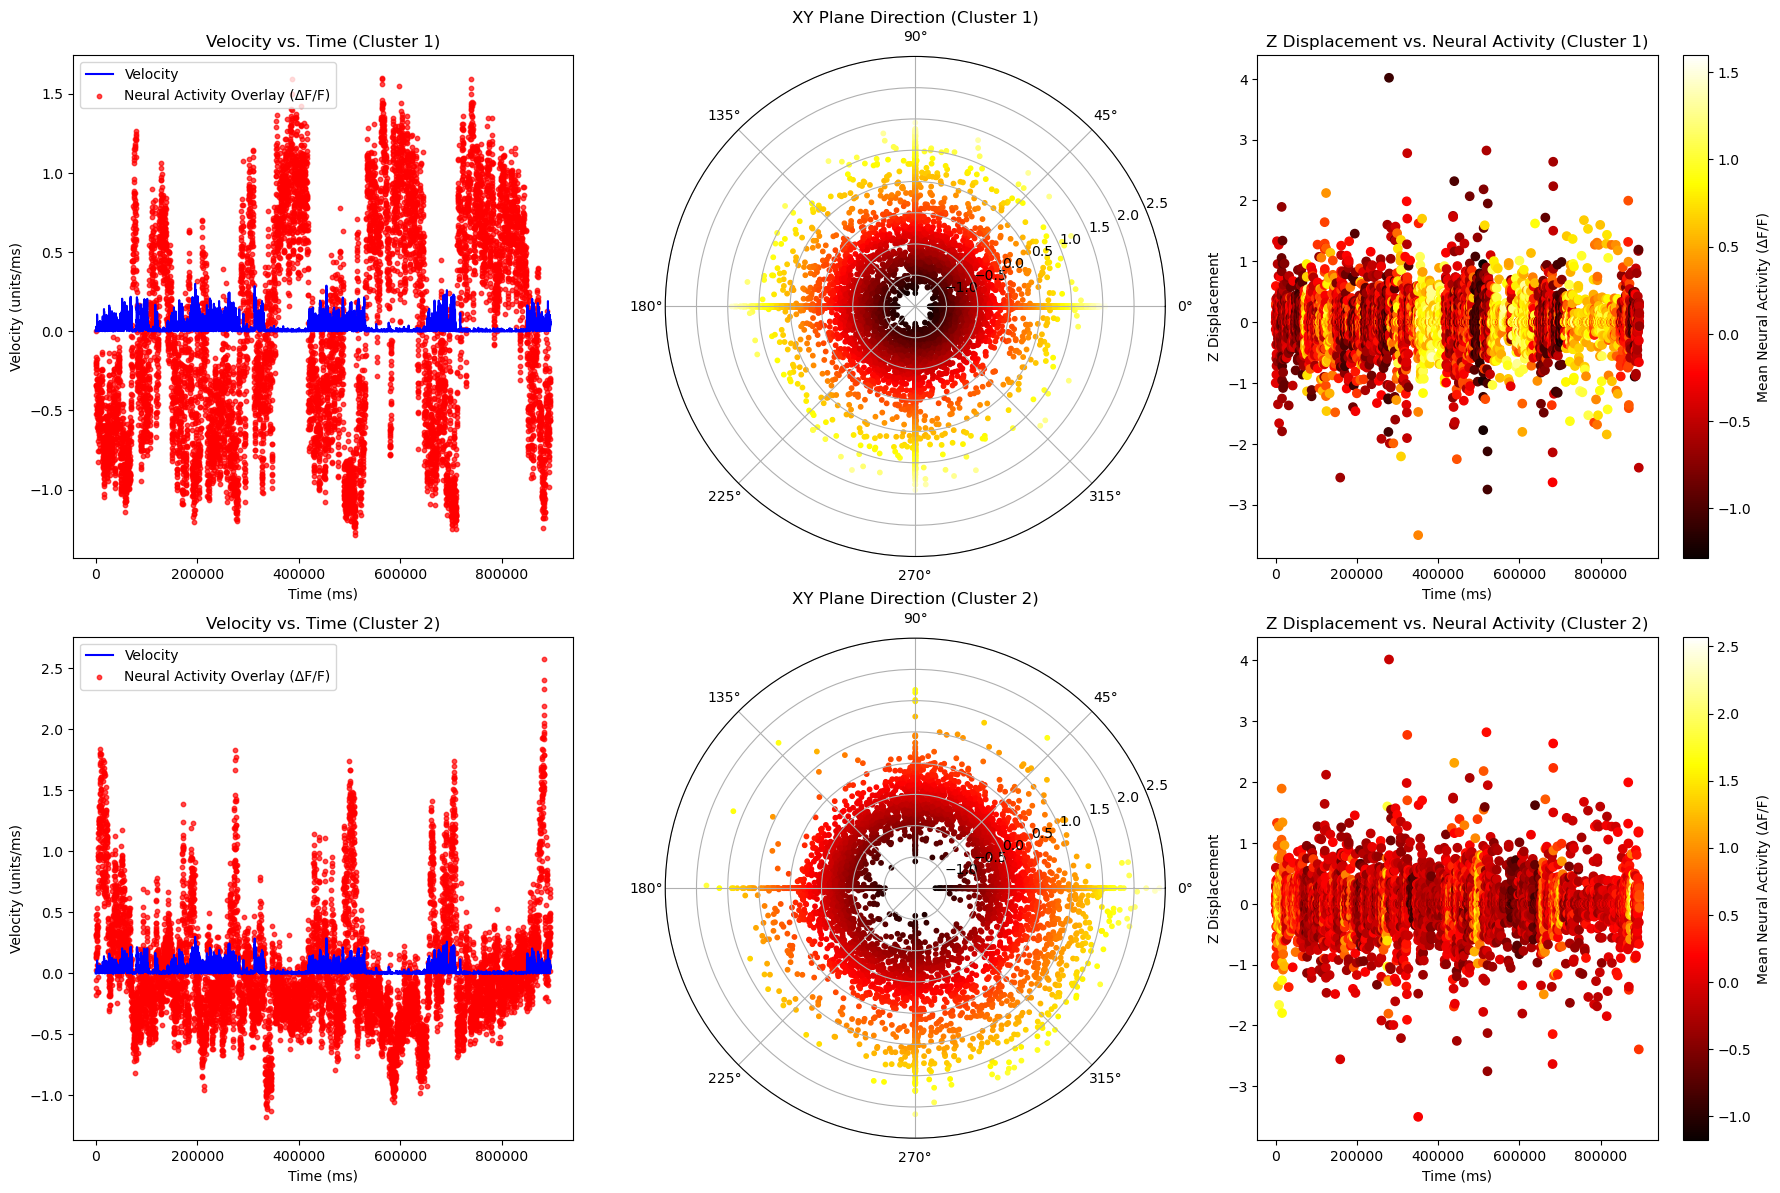

In [44]:
# Determine the maximum value for consistent scaling
# max_xy_direction = max(
#     abs(df_new['xy_direction'].min()),
#     abs(df_new['xy_direction'].max())
# )

# Adjust the scale to include the maximum activity level
rmax = 2.5 #max_xy_direction #+ 0.5  # Add buffer for better visualization
rmin = -1.5
# Plot detailed analysis with overlays
fig = plt.figure(figsize=(18, 12))

for cluster_id in range(num_clusters):
    row_offset = cluster_id * 3  # Offset for each cluster's row

    # Velocity vs. Time
    ax1 = fig.add_subplot(2, 3, row_offset + 1)
    ax1.plot(time, df_new['velocity'], label='Velocity', color='blue')
    ax1.scatter(time, cluster_means[cluster_id, :len(df_new['velocity'])],
                c='red', s=10, label='Neural Activity Overlay (ΔF/F)', alpha=0.7)
    ax1.set_title(f'Velocity vs. Time (Cluster {cluster_id + 1})')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Velocity (units/ms)')
    ax1.legend()

    # XY Direction with Neural Overlay (Polar Plot)
    ax2 = fig.add_subplot(2, 3, row_offset + 2, polar=True)
    scatter_xy = ax2.scatter(df_new['xy_direction'], 
                              cluster_means[cluster_id, :len(df_new['xy_direction'])],
                              c=cluster_means[cluster_id, :len(df_new['xy_direction'])], 
                              cmap='hot', s=10)
    ax2.set_title(f'XY Plane Direction (Cluster {cluster_id + 1})')
    ax2.set_ylim(rmin, rmax)  # Uniform scale for all clusters

    # Z Displacement vs. Neural Activity
    ax3 = fig.add_subplot(2, 3, row_offset + 3)
    scatter_z = ax3.scatter(
        time, df_new['z_displacement'],
        c=cluster_means[cluster_id, :len(df_new['z_displacement'])], cmap='hot', marker='o'
    )
    ax3.set_title(f'Z Displacement vs. Neural Activity (Cluster {cluster_id + 1})')
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Z Displacement')
    fig.colorbar(scatter_z, ax=ax3, label='Mean Neural Activity (ΔF/F)')

plt.tight_layout()
plt.show()


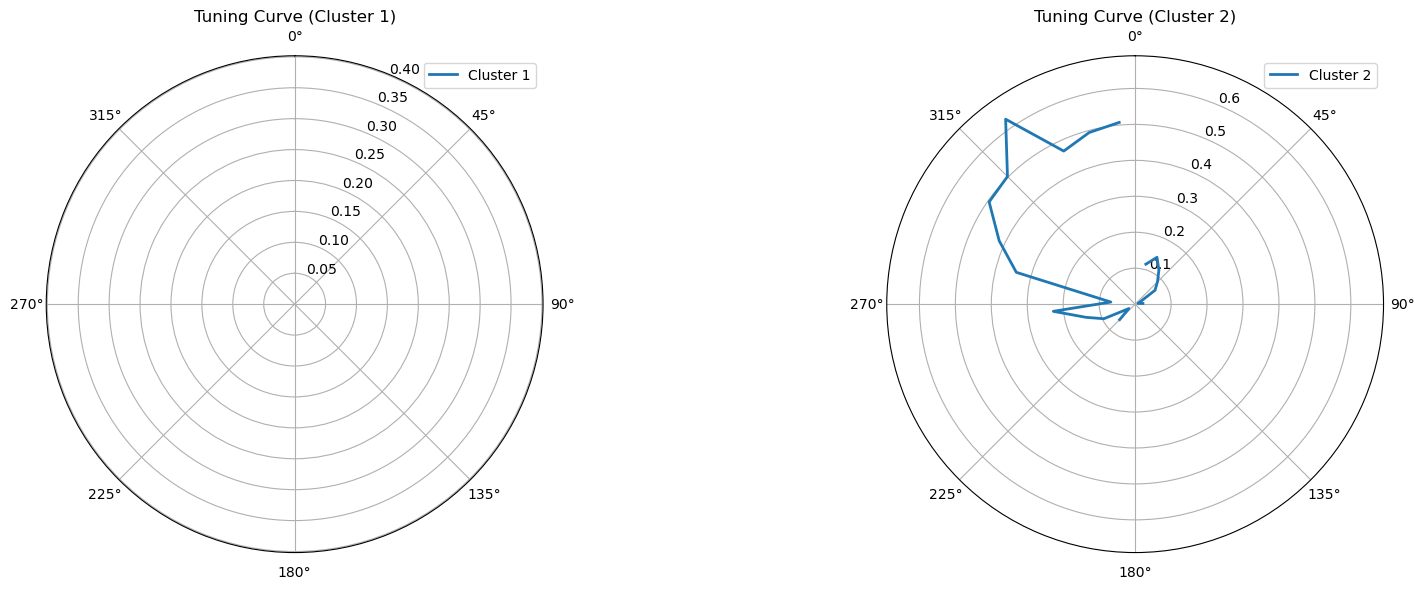

In [64]:
# Number of bins for the angle distribution
num_bins = 36  # Divide 360 degrees into 10-degree bins

# Convert angles to degrees for better interpretability
df_new['xy_direction_deg'] = np.degrees(df_new['xy_direction']) % 360

# Plot tuning curves for each cluster
fig, axs = plt.subplots(1, num_clusters, figsize=(18, 6), subplot_kw={'projection': 'polar'})

for cluster_id in range(num_clusters):
    # Filter data for the current cluster
    cluster_activity = cluster_means[cluster_id, :len(df_new['xy_direction_deg'])]
    cluster_angles = df_new['xy_direction_deg']

    # Bin the data
    bin_edges = np.linspace(0, 360, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute mean neural activity in each bin
    activity_means = []
    for i in range(num_bins):
        in_bin = (cluster_angles >= bin_edges[i]) & (cluster_angles < bin_edges[i + 1])
        activity_means.append(cluster_activity[in_bin].mean() if np.any(in_bin) else 0)

    # Plot the tuning curve
    axs[cluster_id].plot(
        np.radians(bin_centers),  # Convert bin centers to radians for polar plot
        activity_means,
        label=f'Cluster {cluster_id + 1}',
        linewidth=2
    )
    axs[cluster_id].set_title(f'Tuning Curve (Cluster {cluster_id + 1})')
    axs[cluster_id].set_theta_zero_location("N")  # Set 0 degrees to point upward
    axs[cluster_id].set_theta_direction(-1)  # Set direction to clockwise
    axs[cluster_id].set_ylim(0, max(activity_means) + 0.1 * max(activity_means))  # Adjust y-limits for clarity
    axs[cluster_id].legend()

plt.tight_layout()
plt.show()


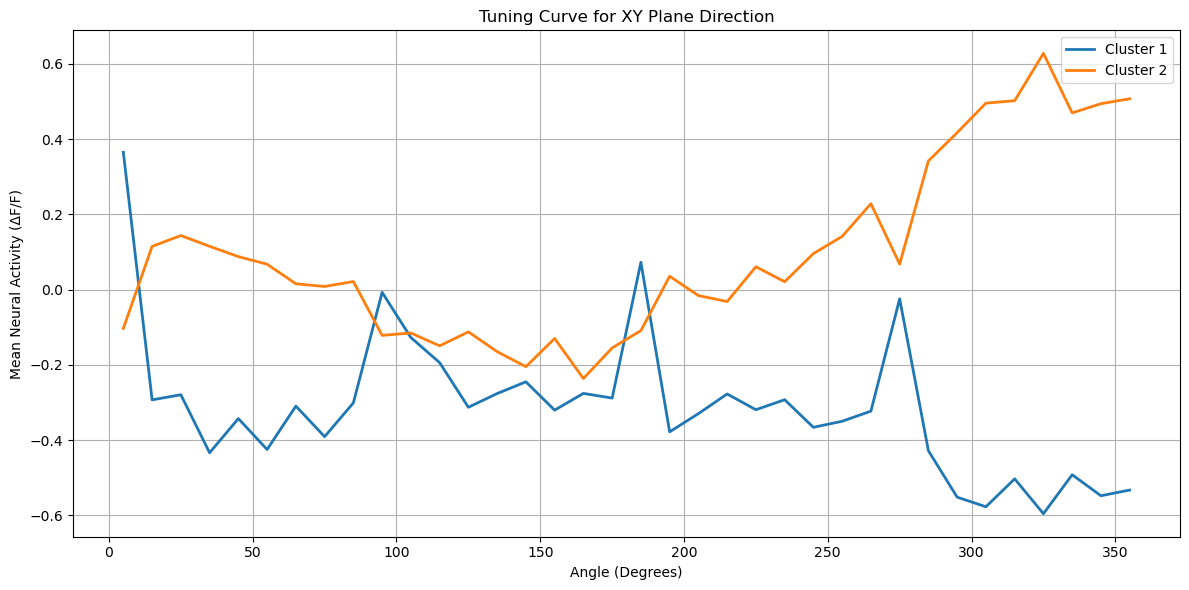

In [68]:
# Number of bins for the angle distribution
num_bins = 36  # Divide 360 degrees into 10-degree bins

# Convert angles to degrees for better interpretability
df_new['xy_direction_deg'] = np.degrees(df_new['xy_direction']) % 360

# Plot tuning curves for each cluster
fig, ax = plt.subplots(figsize=(12, 6))

for cluster_id in range(num_clusters):
    # Filter data for the current cluster
    cluster_activity = cluster_means[cluster_id, :len(df_new['xy_direction_deg'])]
    cluster_angles = df_new['xy_direction_deg']

    # Bin the data
    bin_edges = np.linspace(0, 360, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute mean neural activity in each bin
    activity_means = []
    for i in range(num_bins):
        in_bin = (cluster_angles >= bin_edges[i]) & (cluster_angles < bin_edges[i + 1])
        activity_means.append(cluster_activity[in_bin].mean() if np.any(in_bin) else 0)

    # Plot the tuning curve
    ax.plot(bin_centers, activity_means, label=f'Cluster {cluster_id + 1}', linewidth=2)

# Add plot labels and legend
ax.set_title('Tuning Curve for XY Plane Direction')
ax.set_xlabel('Angle (Degrees)')
ax.set_ylabel('Mean Neural Activity (ΔF/F)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


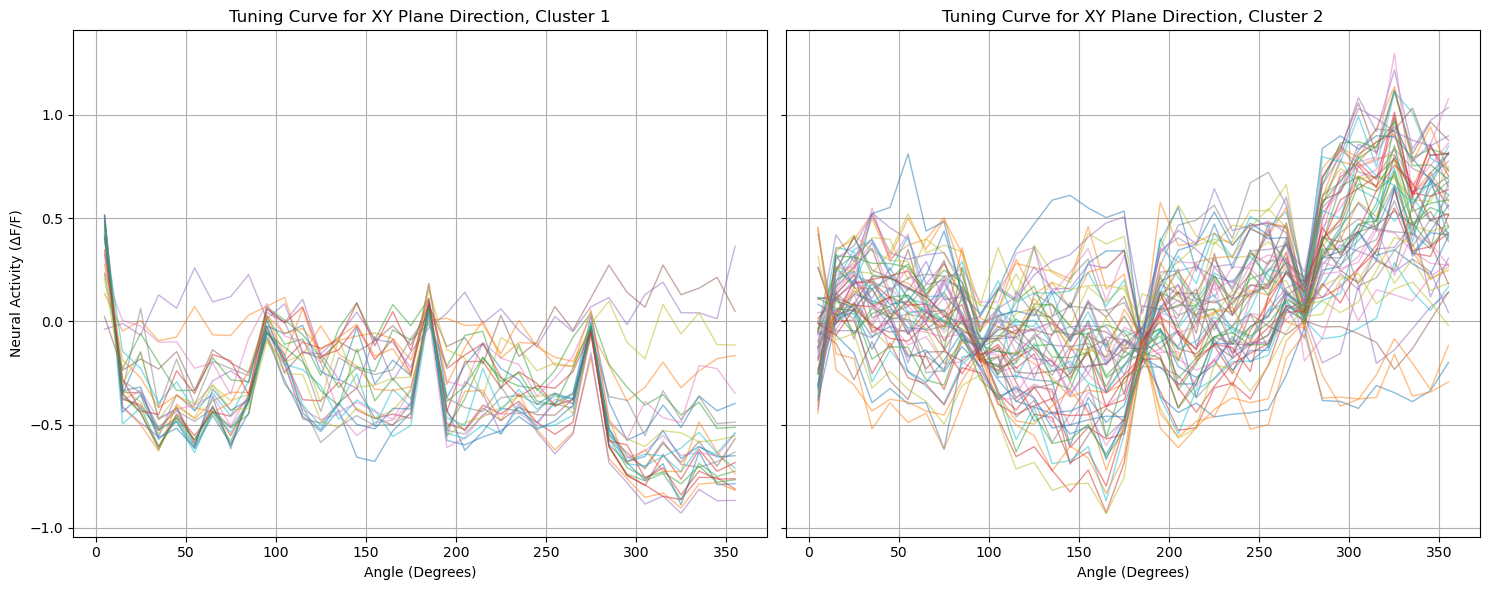

In [71]:
# Number of bins for the angle distribution
num_bins = 36  # Divide 360 degrees into 10-degree bins

# Convert angles to degrees for better interpretability
df_new['xy_direction_deg'] = np.degrees(df_new['xy_direction']) % 360

# Plot individual tuning curves for each cluster
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 6), sharey=True)

for cluster_id in range(num_clusters):
    # Filter data for the current cluster
    cluster_indices = np.where(cluster_labels == cluster_id + 1)[0]
    cluster_angles = df_new['xy_direction_deg']
    
    # Iterate over each neuron in the cluster
    for neuron_idx in cluster_indices:
        # Extract activity for this neuron
        neuron_activity = neuron_activity_normalized[neuron_idx, :]
        
        # Bin the activity by angle
        bin_edges = np.linspace(0, 360, num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        activity_means = []
        for i in range(num_bins):
            in_bin = (cluster_angles >= bin_edges[i]) & (cluster_angles < bin_edges[i + 1])
            activity_means.append(neuron_activity[in_bin].mean() if np.any(in_bin) else 0)
        
        # Plot the tuning curve for the neuron
        axs[cluster_id].plot(bin_centers, activity_means, alpha=0.5, linewidth=1)

    # Set up the axis for the cluster
    axs[cluster_id].set_title(f'Tuning Curve for XY Plane Direction, Cluster {cluster_id + 1}')
    axs[cluster_id].set_xlabel('Angle (Degrees)')
    axs[cluster_id].grid(True)

# Set common Y-axis label
axs[0].set_ylabel('Neural Activity (ΔF/F)')

plt.tight_layout()
plt.show()


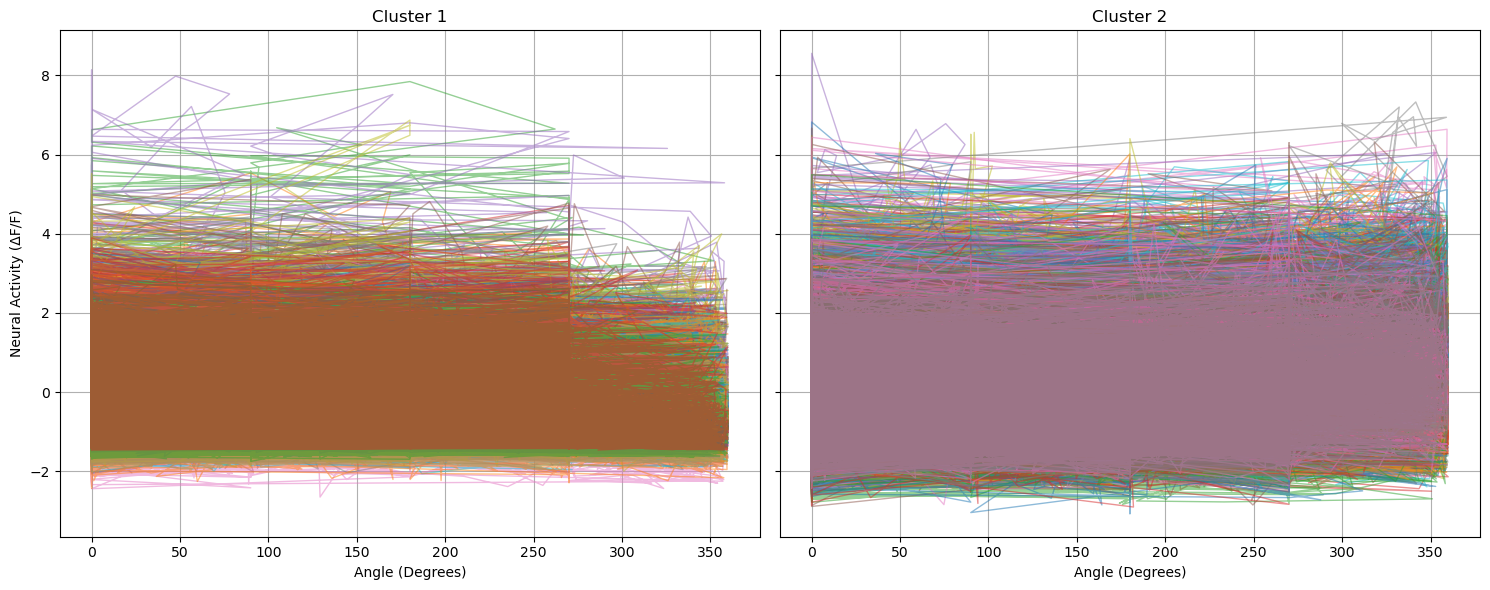

In [72]:
# Convert angles to degrees for better interpretability
df_new['xy_direction_deg'] = np.degrees(df_new['xy_direction']) % 360

# Plot individual tuning curves for each cluster
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 6), sharey=True)

for cluster_id in range(num_clusters):
    # Filter data for the current cluster
    cluster_indices = np.where(cluster_labels == cluster_id + 1)[0]
    
    # Plot each neuron's tuning curve
    for neuron_idx in cluster_indices:
        # Extract activity and corresponding angles for this neuron
        neuron_activity = neuron_activity_normalized[neuron_idx, :]
        neuron_angles = df_new['xy_direction_deg']
        
        # Plot the tuning curve (all raw data points)
        axs[cluster_id].plot(neuron_angles, neuron_activity, alpha=0.5, linewidth=1)

    # Set up the axis for the cluster
    axs[cluster_id].set_title(f'Cluster {cluster_id + 1}')
    axs[cluster_id].set_xlabel('Angle (Degrees)')
    axs[cluster_id].grid(True)

# Set common Y-axis label
axs[0].set_ylabel('Neural Activity (ΔF/F)')

plt.tight_layout()
plt.show()


In [52]:
df_new

timestamp_ms_mini       com_x       com_y      com_z       kp1_x  \
0                   -28   41.706841  527.997575  10.797444   13.583969   
1                    76   41.555597  528.230113   9.798887   12.700958   
2                   173   41.311852  528.230113   9.676444   12.057464   
3                   284   41.311852  528.230113   9.676444   13.367846   
4                   383   41.070991  528.230113   9.798887   13.515869   
...                 ...         ...         ...        ...         ...   
8889             895154  561.426280  491.163603  16.114240  571.295227   
8890             895262  565.447285  492.621053  16.114240  578.877075   
8891             895354  571.293731  496.557728  16.212091  582.323486   
8892             895459  577.088000  499.333136  16.359767  586.190002   
8893             895566  580.981823  499.997958  16.293457  587.839478   

           kp1_y      kp1_z       kp2_x       kp2_y      kp2_z  ...       a_y  \
0     533.438843  19.441160   35.926529  553.407898  19.521400  ...       NaN   
1     533.384277  18.862123   36.603622  552.807739  18.320738  ...       NaN   
2     535.820007  19.843277   36.404842  554.592407  18.491831  ... -0.000023   
3     534.604065  21.027853   38.033424  552.758179  18.725048  ...  0.000000   
4     534.713684  22.168043   39.517872  551.007874  19.403019  ...  0.000000   
...          ...        ...         ...         ...        ...  ...       ...   
8889  516.943359  17.747700  587.236877  493.928833  21.752941  ...  0.000081   
8890  522.396729  18.414005  593.763428  497.212463  21.706463  ... -0.000232   
8891  525.675598  20.198135  600.818298  503.946777  22.326832  ...  0.000318   
8892  531.021606  19.981670  607.503723  510.618591  21.386889  ... -0.000156   
8893  530.803040  25.077442  610.366272  511.941101  25.125677  ... -0.000189   

           a_z  acceleration        dx        dy        dz   angle_deg  \
0          NaN      0.000000  0.000000  0.000000  0.000000         NaN   
1          NaN      0.000000 -0.145937  0.224378 -0.963513  123.040217   
2     0.000086      0.000090 -0.893588  0.000000 -0.448889  180.000000   
3     0.000011      0.000025  0.000000  0.000000  0.000000    0.000000   
4     0.000012      0.000028 -0.891427  0.000000  0.453164  180.000000   
...        ...           ...       ...       ...       ...         ...   
8889 -0.000004      0.000172  0.795960  0.603880  0.042142   37.186931   
8890 -0.000025      0.000265  0.940148  0.340765  0.000000   19.923516   
8891  0.000012      0.000428  0.829405  0.558476  0.013882   33.954151   
8892  0.000003      0.000175  0.901639  0.431878  0.022980   25.594049   
8893 -0.000019      0.000259  0.985597  0.168278 -0.016784    9.689110   

      angle_unwrapped  angle_smoothed  angle_deg_smoothed  
0                 NaN             NaN                 NaN  
1                 NaN             NaN                 NaN  
2                 NaN             NaN                 NaN  
3                 NaN             NaN                 NaN  
4                 NaN             NaN                 NaN  
...               ...             ...                 ...  
8889              NaN             NaN                 NaN  
8890              NaN             NaN                 NaN  
8891              NaN             NaN                 NaN  
8892              NaN             NaN                 NaN  
8893              NaN             NaN                 NaN  

[8894 rows x 262 columns]

In [50]:
print(f"cluster_labels shape: {cluster_labels.shape}")
print(f"df_new shape: {df_new.shape}")


cluster_labels shape: (82,)
df_new shape: (8894, 262)


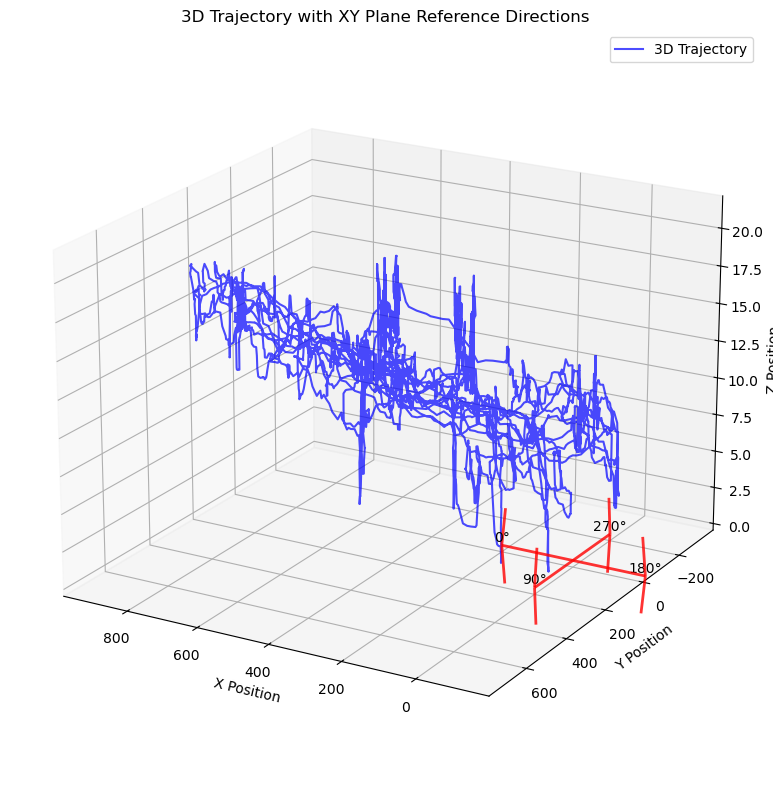

In [35]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define reference angles and arrow lengths
reference_angles = [0, 90, 180, 270]  # Degrees
arrow_length = 200  # Length of the reference arrows
origin = [0, 0, 0]  # Origin for the reference arrows

# Calculate arrow components based on angles
reference_arrows = []
for angle in reference_angles:
    radians = np.deg2rad(angle)
    x = arrow_length * np.cos(radians)
    y = arrow_length * np.sin(radians)
    reference_arrows.append((x, y))

# Plot reference arrows with 3D trajectory
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D trajectory
trajectory = ax.plot(
    df_new['com_x'], df_new['com_y'], df_new['com_z'],
    label='3D Trajectory', color='blue', alpha=0.7
)

# Add reference arrows in the XY plane
for i, (x, y) in enumerate(reference_arrows):
    ax.quiver(
        origin[0], origin[1], origin[2],  # Arrow starting point
        x, y, 0,  # Arrow components (XY plane)
        color='red', alpha=0.8, linewidth=2, arrow_length_ratio=0.05
    )
    # Label the arrows with their angles
    ax.text(
        x, y, 0.5,  # Position slightly above the arrow tip
        f'{reference_angles[i]}°', color='black', fontsize=10, ha='center', va='center'
    )

# Set axis labels and title
ax.set_title('3D Trajectory with XY Plane Reference Directions')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Adjust viewing angle for better visualization
ax.view_init(elev=20, azim=120)

# Add legend
ax.legend(['3D Trajectory'])

plt.tight_layout()
plt.show()


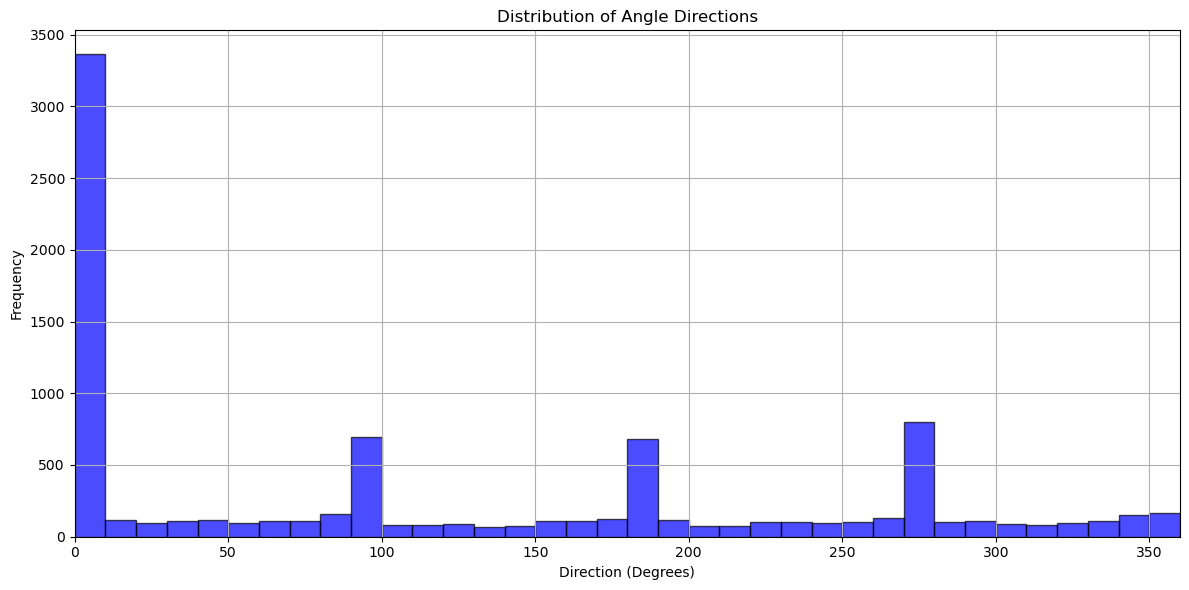

In [74]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot histogram of the direction angles
ax.hist(df_new['angle_deg'], bins=36, range=(0, 360), color='blue', alpha=0.7, edgecolor='black')

# Add labels and title
ax.set_title('Distribution of Angle Directions')
ax.set_xlabel('Direction (Degrees)')
ax.set_ylabel('Frequency')
ax.set_xlim(0, 360)  # Ensure the x-axis spans 0° to 360°
ax.grid(True)

plt.tight_layout()
plt.show()


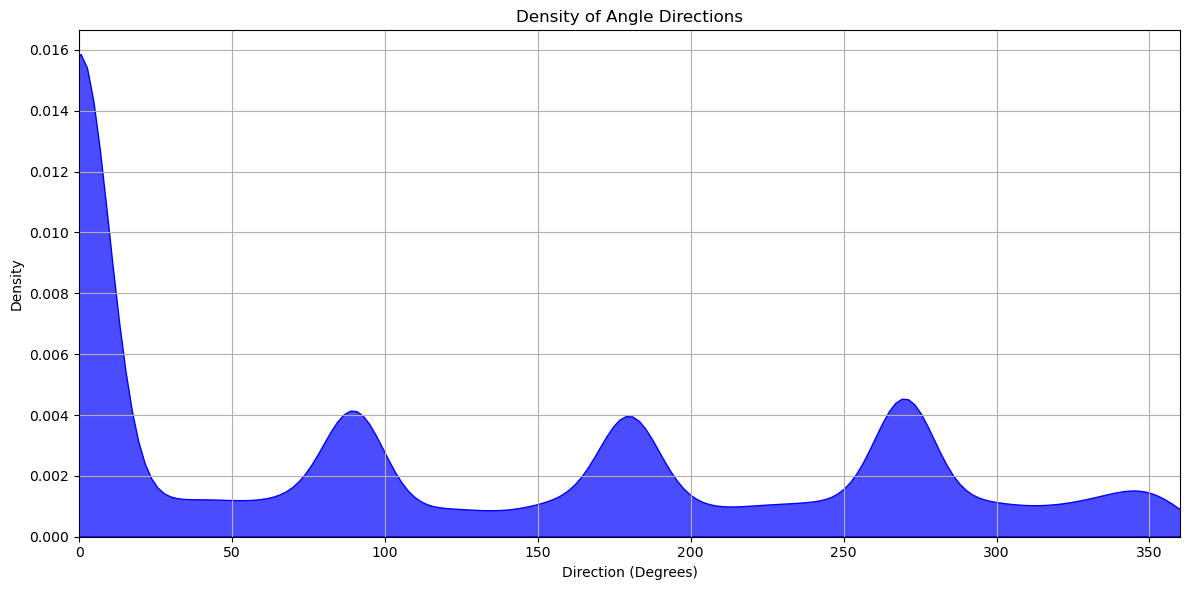

In [75]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))

# Plot KDE of the direction angles
sns.kdeplot(df_new['angle_deg'], bw_adjust=0.5, fill=True, ax=ax, color='blue', alpha=0.7)

# Add labels and title
ax.set_title('Density of Angle Directions')
ax.set_xlabel('Direction (Degrees)')
ax.set_ylabel('Density')
ax.set_xlim(0, 360)  # Ensure the x-axis spans 0° to 360°
ax.grid(True)

plt.tight_layout()
plt.show()


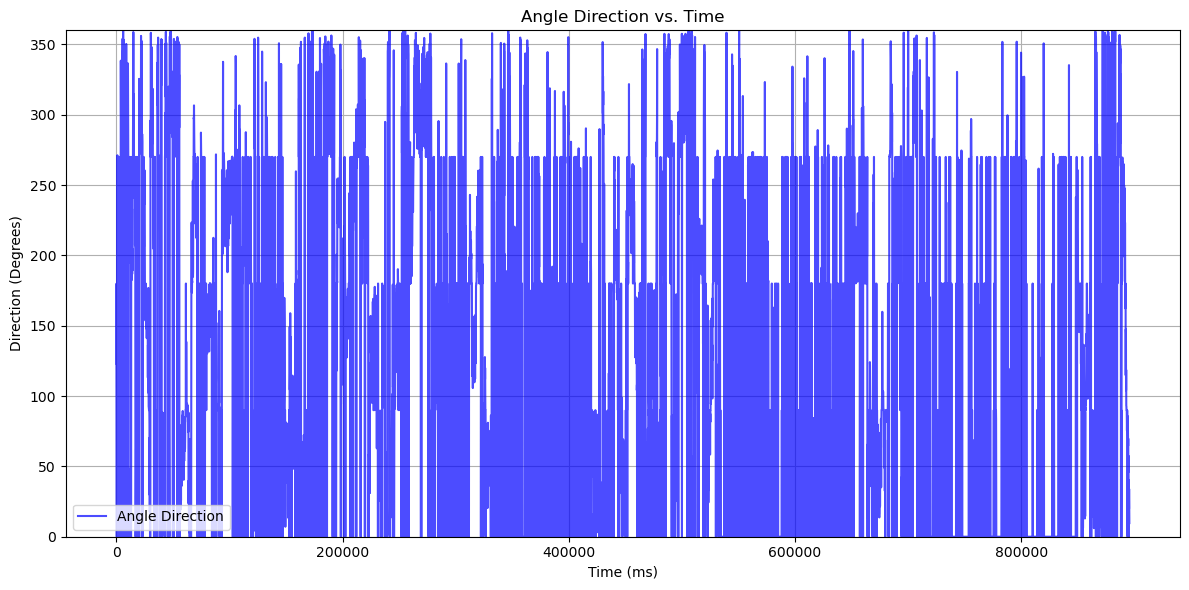

In [73]:
# Plot angle direction vs. time
fig, ax = plt.subplots(figsize=(12, 6))

# Convert angles from radians to degrees for better readability
df_new['angle_deg'] = np.rad2deg(df_new['xy_direction'])

# Wrap angles to stay within 0° to 360° (or -180° to 180° if preferred)
df_new['angle_deg'] = (df_new['angle_deg'] + 360) % 360

# Plot the direction angle over time
ax.plot(time, df_new['angle_deg'], label='Angle Direction', color='blue', alpha=0.7)

# Add labels and title
ax.set_title('Angle Direction vs. Time')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Direction (Degrees)')
ax.set_ylim(0, 360)  # Ensure the y-axis spans 0° to 360°
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


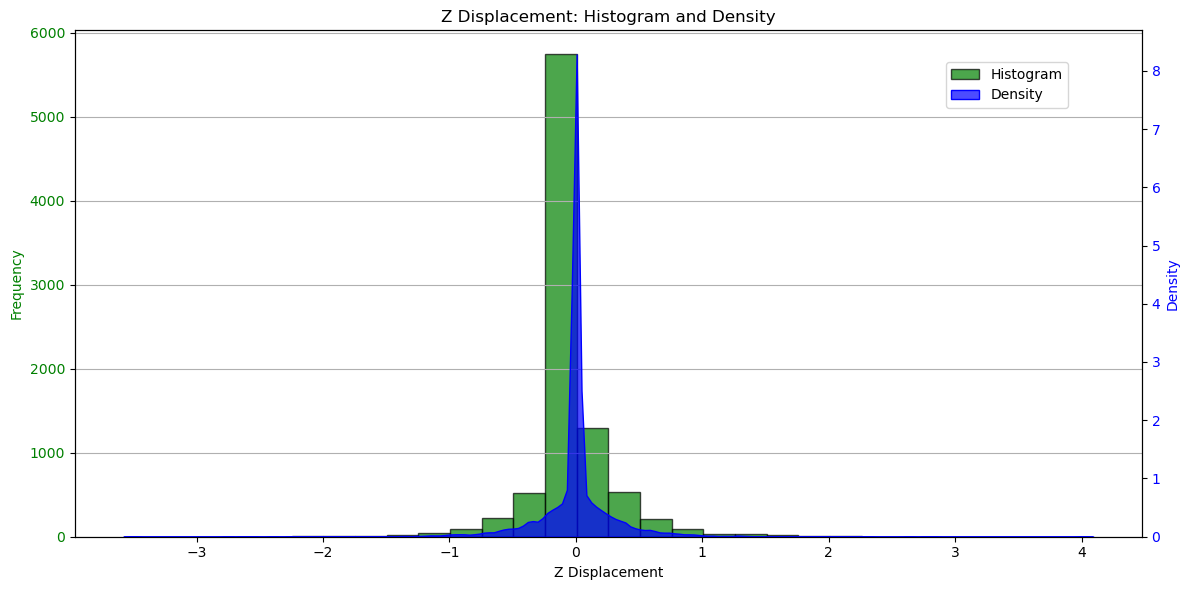

In [79]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Histogram for z displacement
color_hist = 'green'
ax1.hist(df_new['z_displacement'], bins=30, color=color_hist, alpha=0.7, edgecolor='black', label='Histogram')
ax1.set_title('Z Displacement: Histogram and Density')
ax1.set_xlabel('Z Displacement')
ax1.set_ylabel('Frequency', color=color_hist)
ax1.tick_params(axis='y', labelcolor=color_hist)
ax1.grid(True, axis='y')

# Add a second y-axis for the density
ax2 = ax1.twinx()
color_density = 'blue'
sns.kdeplot(df_new['z_displacement'], bw_adjust=0.5, fill=True, ax=ax2, color=color_density, alpha=0.7, label='Density')
ax2.set_ylabel('Density', color=color_density)
ax2.tick_params(axis='y', labelcolor=color_density)
ax2.grid(False)

# Add legends for both
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()
